In [ ]:
### Jad Kutbi

import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the MixUp data function
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# MixUp criterion function
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
# Define the directory for your dataset
data_dir = r'C:\Users\jadku\Documents\dates\dataset'

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ImageNet preprocessing for ConvNeXt_base pretrained
transform = transforms.Compose([
    ConvNeXt_Tiny_Weights.IMAGENET1K_V1.transforms(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomErasing(p=0.5)
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
])


# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into train (70%), val (15%), and test (15%) sets
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Define data loaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Load the pretrained ConvNeXt_base model
model = convnext_tiny(pretrained=True)

# Modify the classifier to fit the number of classes in your dataset
num_classes = len(full_dataset.classes)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)

# Move the model to the device (GPU or CPU)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Function for validation
def validate(model, val_loader):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Early stopping parameters
best_val_loss = float('inf')
patience = 6  # Stop training if no improvement after 'patience' epochs
epochs_no_improve = 0
early_stop = False

# Set the number of epochs
num_epochs = 50  # Increased number of epochs
best_model_path = "best_convnext_model_mix.pth"  # Path to save the best model

# Training loop with validation and early stopping
for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping activated.")
        break

    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Apply MixUp
        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validate at the end of each epoch
    val_loss, val_acc = validate(model, val_loader)
    scheduler.step(val_loss)  # Adjust learning rate based on validation loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {running_loss / len(train_loader):.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Early stopping and model checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch + 1}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True
            print("No improvement for several epochs, stopping training early.")

print("Training completed.")

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Test the model on the test set
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and labels for further analysis
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Predictions output (optional)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Print a few sample predictions and their true labels
for i in range(10):  # Print first 10 predictions as example
    print(f'Predicted: {train_dataset.dataset.classes[all_preds[i]]}, '
          f'Actual: {train_dataset.dataset.classes[all_labels[i]]}')


C:\Users\jadku\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jadku\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\jadku\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/50], Train Loss: 1.8124, Val Loss: 1.1561, Val Accuracy: 59.74%
Best model saved at epoch 1
Epoch [2/50], Train Loss: 1.4860, Val Loss: 1.1773, Val Accuracy: 60.06%
Epoch [3/50], Train Loss: 1.3086, Val Loss: 0.7041, Val Accuracy: 75.00%
Best model saved at epoch 3
Epoch [4/50], Train Loss: 1.2243, Val Loss: 0.5872, Val Accuracy: 85.39%
Best model saved at epoch 4
Epoch [5/50], Train Loss: 1.0410, Val Loss: 0.4788, Val Accuracy: 88.64%
Best model saved at epoch 5
Epoch [6/50], Train Loss: 0.8898, Val Loss: 0.3116, Val Accuracy: 88.64%
Best model saved at epoch 6
Epoch [7/50], Train Loss: 0.9960, Val Loss: 0.3601, Val Accuracy: 90.91%
Epoch [8/50], Train Loss: 0.9449, Val Loss: 0.3439, Val Accuracy: 92.53%
Epoch [9/50], Train Loss: 0.9830, Val Loss: 0.3302, Val Accuracy: 93.83%
Epoch [10/50], Train Loss: 0.8729, Val Loss: 0.2399, Val Accuracy: 94.81%
Best model saved at epoch 10
Epoch [11/50], Train Loss: 0.9365, Val Loss: 0.2961, Val Accuracy: 93.51%
Epoch [12/50], Train Loss:

In [7]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the MixUp data function
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# MixUp criterion function
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
# Define the directory for your dataset
data_dir = r'C:\Users\jadku\Documents\dates\dataset'

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ImageNet preprocessing for ConvNeXt_base pretrained
transform = transforms.Compose([
    ConvNeXt_Tiny_Weights.IMAGENET1K_V1.transforms(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomErasing(p=0.5)
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
])


# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into train (70%), val (15%), and test (15%) sets
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Define data loaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Load the pretrained ConvNeXt_base model
model = convnext_tiny(pretrained=True)

# Modify the classifier to fit the number of classes in your dataset
num_classes = len(full_dataset.classes)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)

# Move the model to the device (GPU or CPU)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)



C:\Users\jadku\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jadku\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\jadku\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


C:\Users\jadku\AppData\Local\Temp\ipykernel_38108\3655469495.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48189062..1.7764271].


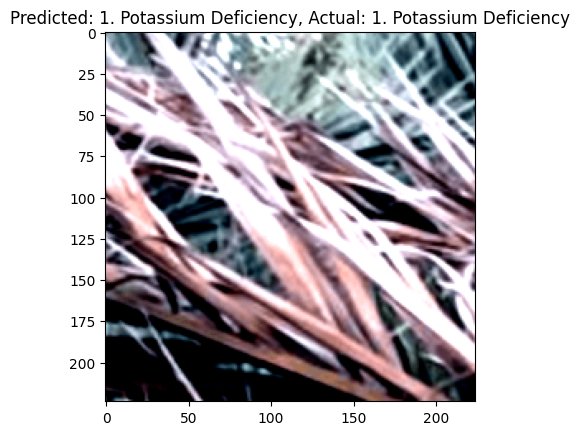

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4133916..1.82].


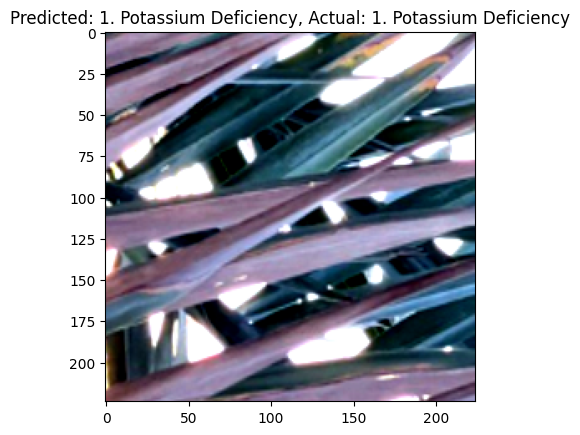

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46476585..1.7589979].


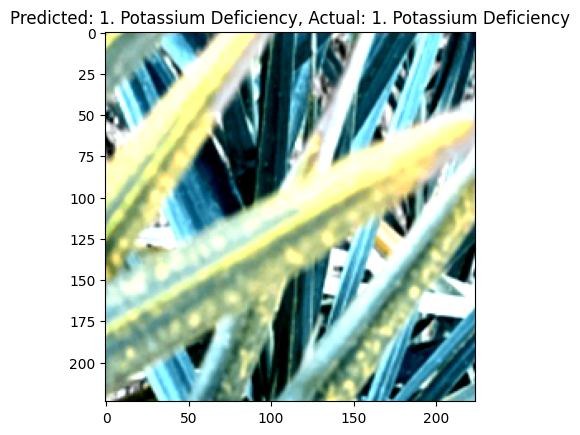

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display an image
def imshow(img, title=None):
    """Display an image."""
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Test the model on the test set
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and labels for further analysis
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Predictions output
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Display first 10 test images, along with predicted and actual labels
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show first 10 images
for i in range(11,14):
    imshow(images[i], title=f'Predicted: {train_dataset.dataset.classes[all_preds[i]]}, Actual: {train_dataset.dataset.classes[all_labels[i]]}')


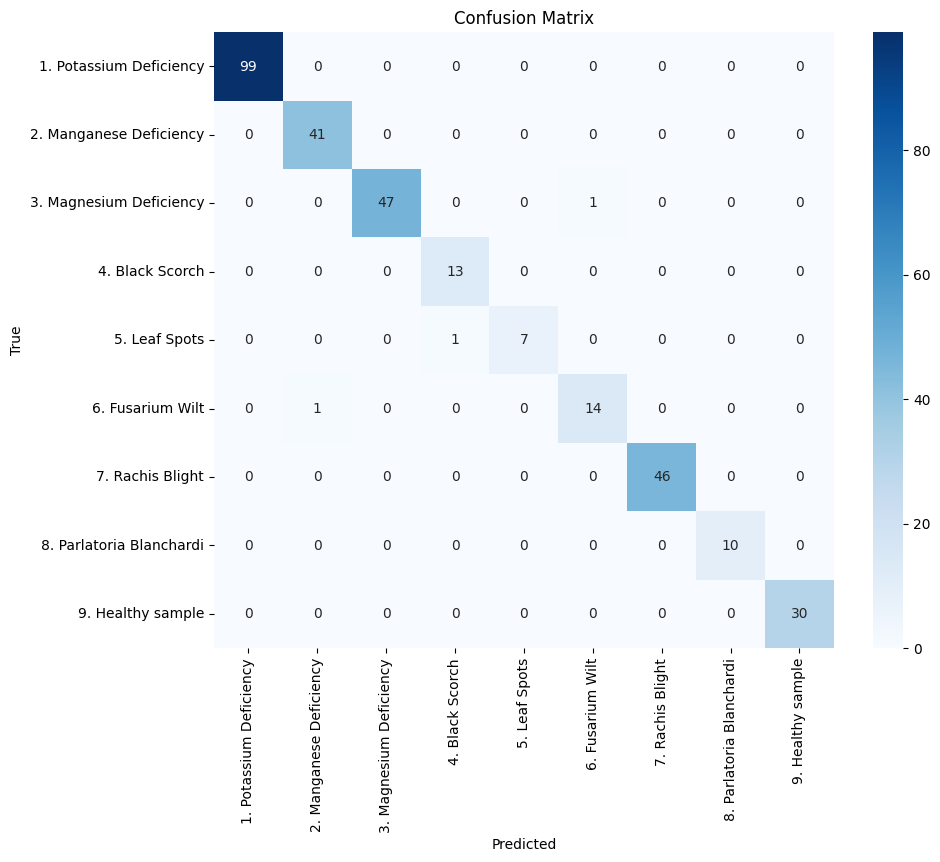

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
